In [20]:
import pandas as pd
import numpy as np
np.random.seed(1)

import seaborn as sns
import seaborn.objects as os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Chap 4. 시계열 데이터의 시뮬레이션
- 시뮬레이션으로 시계열 데이터를 생성하는 방법
    - 발견적 시뮬레이션 (heuristic) : 세상이 움직여야 하는 타당한 방식 결정 후 코드로 옮김
    - 이산사건 시뮬레이션 (discrete event) : 세상의 규칙을 적용받는 개별 액터를 만들고 실행하여 관차
    - 물리기반 시뮬레이션 (physics-based) : 물리법칙 적용하여 진화방식 관찰

## 4.1 시계열 시뮬레이션의 특별한 점
## 4.1.1 시뮬레이션과 예측
- 정성적 관측을 예측보다 시뮬레이션에 통합하는 것이 더 쉬울 수 있음
- 시뮬레이션은 확장 가능한 형태로 실행되므로 여러 시나리오 관찰 가능 / 예측은 시뮬레이션보다 신중하게 처리 필요
- 시뮬레이션은 예측보다 위험부담이 적음 : 가상이므로 실제 자원의 투입이 필요없음
    => 처음부터 창의적이고 탐구적인 자세로 시뮬레이션 설계 가능
    

## 4.2 코드로 보는 시뮬레이션
### 4.2.1 직접 만들어보기
- 회원 수, 각 회원의 가입시점, 각 회원의 대한 상태정보
- 모든 회원에게 특정 가입 연도를 무작위로 부여하고, 가입 연도에 따라 상탲어보 결정
- 주별로 회원의 이메일 열람 시점을 나타내는 테이블 생성. 한 주에 이메일 세 통을 보내는 기관의 행동을 정의하고 회원들 행동 패턴은 다음과 같이 정의 : 열람한 적이 없음, 일정한 수준의 이메일 열람 및 참여율, 참여 수준의 증가 혹은 감소

In [21]:
years = [2014, 2015, 2016, 2017, 2018]
member_status = ['bronze', 'silver', 'gold' ,'inactive']

member_years = np.random.choice(years, 1000, p=[0.1, 0.1, 0.15, 0.3, 0.35])
member_stats = np.random.choice(member_status, 1000, p=[0.5, 0.3, 0.1, 0.1])

year_joined = pd.DataFrame({'year_joined': member_years, 'member_stats':member_stats})

NUM_EMAILS_SENT_WEEKLY = 3

# 구분되는 행동 시뮬레이션
def never_opens(period_rng):
    return []

def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))

    return num_opened

def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))

def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def open_rate_with_factor_change(period_rng, fac):
    if len(period_rng) < 1 :
        return []
    
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    num_opened = np.zeros(len(period_rng))
    
    for prd in range(0, len(period_rng), 2):
        try:
            n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0,1)
            num_opened[prd:(prd+2)] = np.random.binomial(n, p, 2)
            p = max(min(1, p*fac), 0)
            
        except:
            num_opened[prd] = np.random.binomial(n, p, 1)
    for t in range(len(times)):
        num_opened[times[t]] = 0
    return num_opened

# 기부 행동 모델링
def produce_donations(period_rng, memeber_behavior, num_emails, use_id, member_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    member_has = np.random.choice(donation_amounts)
    # 회원 자격 기간에 따라 기부의 전체 횟수 정함
    email_fraction = num_emails / (NUM_EMAILS_SENT_WEEKLY * len(period_rng))
    member_gives = member_has * email_fraction
    member_gives_idx = np.where(member_gives >= donation_amounts)[0][-1]
    member_gives_idx = max(min(member_gives_idx, len(donation_amounts) - 2), 1)

    # 회원별 재정상태 생성 : "안정적 재산의 양이 기부양에 연관이 있다는 가설"
    num_times_gave = np.random.poisson(2) * (2018 - member_join_year)
    times = np.random.randint(0, len(period_rng), num_times_gave)
    dons = pd.DataFrame({'member':[], 'amount':[], 'timestamp':[]})
    
    for n in range(num_times_gave):
        donation = donation_amounts[member_gives_idx + np.random.binomial(1, .3)]
        ts = str(period_rng[times[n]].start_time + random_weekly_time_delta())
        dons = dons.append(pd.DataFrame(
                {
                    'member' : [use_id],
                    'amount' : [donation],
                    'timestamp' : [ts]
                }
            ))
        if dons.shape[0] > 0:
            dons = dons.loc[dons['amount'] != 0]
            
            return dons
        

# 회원의 행동은 특정 타임스탬프와 연관 => 각 주 내 기부 시점을 고르는 시뮬레이션 코드
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minutes_of_hour = [m for m in range(60)]
    seconds_of_minute = [s for s in range(60)]
    
    return pd.Timedelta(str(np.random.choice(days_of_week)) + ' days') + \
        pd.Timedelta(str(np.random.choice(hours_of_day)) + ' hours') + \
        pd.Timedelta(str(np.random.choice(minutes_of_hour)) + ' minutes') + \
        pd.Timedelta(str(np.random.choice(seconds_of_minute)) + ' seconds')

# Simulation
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
member_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])

rng = pd.period_range('2015-02-14', '2018-06-01', freq='W')
emails = pd.DataFrame({'member':[], 'week':[], 'emails_opened':[]})
donations = pd.DataFrame({'member' : [], 'amount' : [], 'tumestamp':[]})

for idx in range(year_joined.shape[0]):
    # 회원 가입시기 무작위 생성
    join_date = pd.Timestamp(year_joined.iloc[idx].year_joined) + pd.Timedelta(str(np.random.randint(0, 365)) + ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))
    
    # 가입 전에는 타임스탬프 없어야 함
    member_rng = rng[rng.start_time > join_date]
    if len(member_rng) < 1:
        continue
    
    info = member_behaviors[idx](member_rng)
    if len(info) == len(member_rng):
        emails = emails.append(
            pd.DataFrame(
                {
                    'member' : [idx] * len(info),
                    'week' : [str(r.start_time) for r in member_rng],
                    'emails_opened' : info
                }
            )
        )
        donations = donations.append(produce_donations(member_rng, member_behaviors[idx], sum(info), idx, join_date.year))
    

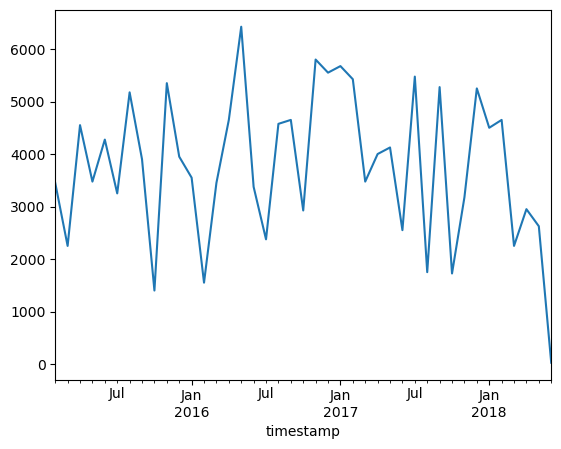

In [25]:
# 월 발생 기부 총합 그래프
df = donations
df.set_index(pd.to_datetime(df['timestamp']), inplace=True)
df.sort_index(inplace=True)
df.groupby(pd.Grouper(freq='M')).amount.sum().plot();

해당 모델의 결정 과정
- 시계열의 갯수 결정
- 시간에 따라 모델링 추세 결정
    - 이메일의 경우 안정되거나, 증가하거나, 감소하는 세 가지 추세
    - 기부의 경우 총기간 동안 열람 메일 갯수에 관련하여 안정적인 행동패턴 생성 => 사전관찰이 포함되지만 데이터 생성 과정에서 이메일 열람을 많이하면 기부빈도 높일 수 있음
- 회원가입 이전에는 이메일 열람하거나 기부하지 않도록
- 시뮬레이션이 목적이라면 데이터 누수 발생하더라도 괜찮으나, 현실적 데이터를 제공하기 위해 데이터가 미래로 누수되지 않도록 해야 함
- 코드의 어색한 부분 + 예외 상황 존재 가능 => 표준적인 유효성 및 유효성에 대한 외부측정기준을 시뮬레이션 전에 적립 필요

## 4.2.2 스스로 실행하는 시뮬레이션 세계 구축
- 제너레이터 : 독립적이가너 의존적인 일련의 액터를 생성하고, 시간을 돌려가며 각 액터가 하는 일 관찰

- 택시 시뮬레이션 : 서로 다른 시간에 교대근무가 예정된 택시 무리의 전체 행동 방식 상상